# Ciencia de datos con variables finales

### Import libreries

In [3]:
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
import seaborn as sns
# para PpostgresSQL
import psycopg2
from scipy.stats import kendalltau

In [4]:
# quitar notacion cientifica
pd.set_option('display.float_format', '{:.5f}'.format)
# parametros bd
database="sernapesca"
user="postgres"
password="admin"
host="127.0.0.1"
port="5432"

In [25]:
def get_raw_data():
    '''Funcion que devuelve la lista de nodos'''
    #Ingreso de parametros de conexion
    con = psycopg2.connect(database = database, user = user, 
                           password = password, host = host, port = port)
    #Creacion de conexion
    cur = con.cursor()
    #Ejecuta la conexion
    cur.execute(f''' 
                SELECT 
                    social.id, 
                    social.personas_norm, -- normalized
                    social.pobl_depend_norm, -- normalized
                    economic_norm.sii_norm, --normalized
                    economic_robust.conteo_plantas_robust_scaled, -- normalized
                    response.prop_respuesta_robust_scaled, --robus scaling
                    hazard.dist_hazard_robust_scaled, -- robust scaling
                    hazard.near_ccaa_robust_scaled,
                    prob_hazard.hazard_prob_robust_scaled,
                    risk.risk_norm
                FROM 
                    capas_estaticas.social_vulnerability_normalized as social
                JOIN
                    capas_estaticas.economic_vulnerability_normalized as economic_norm
                    USING(id)
                JOIN    
                    capas_estaticas.economic_vulnerability_robust_scaling as economic_robust
                    USING(id)
                JOIN 
                    capas_estaticas.response_capacity_robust_scaling as response
                    USING(id)
                JOIN 
                    capas_estaticas.exposure_to_hazard_robust_scaling as hazard
                    USING(id)
                JOIN 
                    capas_estaticas.probability_hazard_robust_scaling as prob_hazard
                    USING(id)
                    
                JOIN 
                    capas_estaticas.risk as risk
                    USING(id)
                WHERE social.id NOT IN (10339, 12256)
                
                '''
                )
    #Ordena la consulta
    table = cur.fetchall()
    print("Table of raw data created successfully")
    #Se cierra la conexion
    con.close()
    #Paso a Pandas DataFrame
    table = pd.DataFrame.from_records(table,
                                          columns = ['id','Población norm','Población dependiente norm','Cantidad empresas SII norm','Cantidad plantas RS','Proporción de respuesta RS','Distancia a amenaza RS','Cantidad CCAA cercanos RS','Probabilidad de amenaza RS', 'Riesgo'])
    return table
#'Población','Población dependiente','Cantidad empresas SII','Cantidad plantas','Distancia a amenaza','Cantidad CCAA cercanos','Probabilidad de amenaza','Proporción de respuesta'

In [26]:
# se trae la consulta a la variable raw_data
risk = get_raw_data()
# fist rows
risk.head()

Table of raw data created successfully


,id,Población norm,Población dependiente norm,Cantidad empresas SII norm,Cantidad plantas RS,Proporción de respuesta RS,Distancia a amenaza RS,Cantidad CCAA cercanos RS,Probabilidad de amenaza RS,Riesgo
0,8708,0.14920828258221680877,0.18099547511312217195,0.00722021660649819495,0.00000,0.08631,-0.47287,7.50000,0.00000,0.02041
1,8709,0E-20,0E-20,0E-20,0.00000,-3.22856,0.30556,3.50000,0.00000,0.00340
2,8710,0E-20,0E-20,0E-20,0.00000,-3.22856,0.16613,0.50000,0.00000,0.00340
3,8711,0E-20,0E-20,0E-20,0.00000,-3.22856,-0.03803,1.00000,0.00000,0.00340
4,8712,0E-20,0E-20,0.00361010830324909747,0.00000,-0.70294,-0.09291,0.50000,0.00000,0.00246


In [27]:
risk

,id,Población norm,Población dependiente norm,Cantidad empresas SII norm,Cantidad plantas RS,Proporción de respuesta RS,Distancia a amenaza RS,Cantidad CCAA cercanos RS,Probabilidad de amenaza RS,Riesgo
0,8708,0.14920828258221680877,0.18099547511312217195,0.00722021660649819495,0.00000,0.08631,-0.47287,7.50000,0.00000,0.02041
1,8709,0E-20,0E-20,0E-20,0.00000,-3.22856,0.30556,3.50000,0.00000,0.00340
2,8710,0E-20,0E-20,0E-20,0.00000,-3.22856,0.16613,0.50000,0.00000,0.00340
3,8711,0E-20,0E-20,0E-20,0.00000,-3.22856,-0.03803,1.00000,0.00000,0.00340
4,8712,0E-20,0E-20,0.00361010830324909747,0.00000,-0.70294,-0.09291,0.50000,0.00000,0.00246
...,...,...,...,...,...,...,...,...,...,...
11040,74547,0.02436053593179049939,0.02941176470588235294,0E-20,0.00000,0.55987,0.55497,0.00000,0.00000,0.00045
11041,74548,0.09622411693057247259,0.10859728506787330317,0.01444043321299638989,0.00000,-0.16174,0.54226,0.00000,0.00000,0.01186
11042,74549,0.00852618757612667479,0E-20,0.01444043321299638989,0.00000,-0.16174,0.54951,0.00000,0.00000,0.00112
11043,74550,0.11814859926918392205,0.07918552036199095023,0.01444043321299638989,0.00000,-0.07154,0.54629,0.00000,0.00000,0.01186


In [28]:
risk.describe()

,id,Cantidad plantas RS,Proporción de respuesta RS,Distancia a amenaza RS,Cantidad CCAA cercanos RS,Probabilidad de amenaza RS,Riesgo
count,11045.00000,11045.00000,11045.00000,11045.00000,11045.00000,11045.00000,11045.00000
mean,50699.42091,0.45866,-0.64689,0.09151,2.06503,0.02437,0.03058
std,28465.03130,0.64442,1.39223,0.83292,6.95708,0.07220,0.07919
min,8708.00000,0.00000,-3.22856,-1.13176,0.00000,0.00000,0.00000
25%,11470.00000,0.00000,-0.74476,-0.41597,0.00000,0.00000,0.00153
50%,68980.00000,0.00000,0.00006,0.00000,0.00000,0.00000,0.00446
75%,71741.00000,1.00000,0.24849,0.58403,1.00000,0.00000,0.01924
max,74551.00000,2.00000,0.55987,3.85952,79.50000,0.35252,1.00000


In [29]:
risk_wo_na = risk.dropna()
risk_wo_na

,id,Población norm,Población dependiente norm,Cantidad empresas SII norm,Cantidad plantas RS,Proporción de respuesta RS,Distancia a amenaza RS,Cantidad CCAA cercanos RS,Probabilidad de amenaza RS,Riesgo
0,8708,0.14920828258221680877,0.18099547511312217195,0.00722021660649819495,0.00000,0.08631,-0.47287,7.50000,0.00000,0.02041
1,8709,0E-20,0E-20,0E-20,0.00000,-3.22856,0.30556,3.50000,0.00000,0.00340
2,8710,0E-20,0E-20,0E-20,0.00000,-3.22856,0.16613,0.50000,0.00000,0.00340
3,8711,0E-20,0E-20,0E-20,0.00000,-3.22856,-0.03803,1.00000,0.00000,0.00340
4,8712,0E-20,0E-20,0.00361010830324909747,0.00000,-0.70294,-0.09291,0.50000,0.00000,0.00246
...,...,...,...,...,...,...,...,...,...,...
11040,74547,0.02436053593179049939,0.02941176470588235294,0E-20,0.00000,0.55987,0.55497,0.00000,0.00000,0.00045
11041,74548,0.09622411693057247259,0.10859728506787330317,0.01444043321299638989,0.00000,-0.16174,0.54226,0.00000,0.00000,0.01186
11042,74549,0.00852618757612667479,0E-20,0.01444043321299638989,0.00000,-0.16174,0.54951,0.00000,0.00000,0.00112
11043,74550,0.11814859926918392205,0.07918552036199095023,0.01444043321299638989,0.00000,-0.07154,0.54629,0.00000,0.00000,0.01186


## Clustering k-means

#### Elbow method

In [30]:
X = risk[["Población norm", "Población dependiente norm","Cantidad empresas SII norm","Cantidad plantas RS","Proporción de respuesta RS","Distancia a amenaza RS",'Cantidad CCAA cercanos RS','Probabilidad de amenaza RS']]
#'Población norm','Población dependiente norm','Cantidad empresas SII norm','Cantidad plantas RS','Proporción de respuesta RS','Distancia a amenaza RS','Cantidad CCAA cercanos RS','Probabilidad de amenaza RS', 'Riesgo'

In [31]:
sse = []

In [32]:
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    sse.append(kmeans.inertia_)

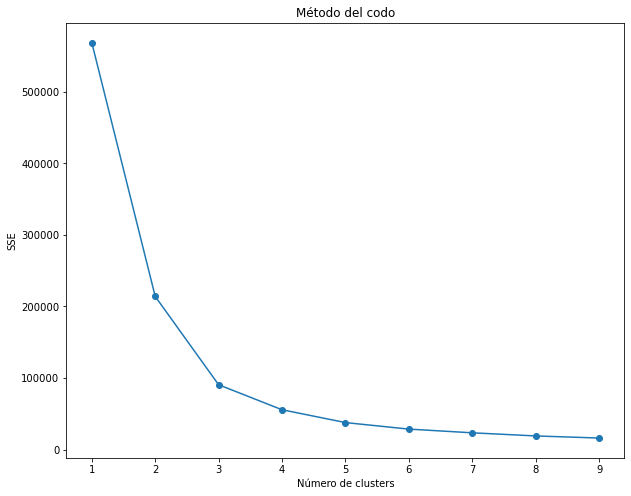

In [33]:
plt.plot(range(1, 10), sse, marker='o')
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('SSE')
plt.show()

TypeError: '<=' not supported between instances of 'str' and 'int'

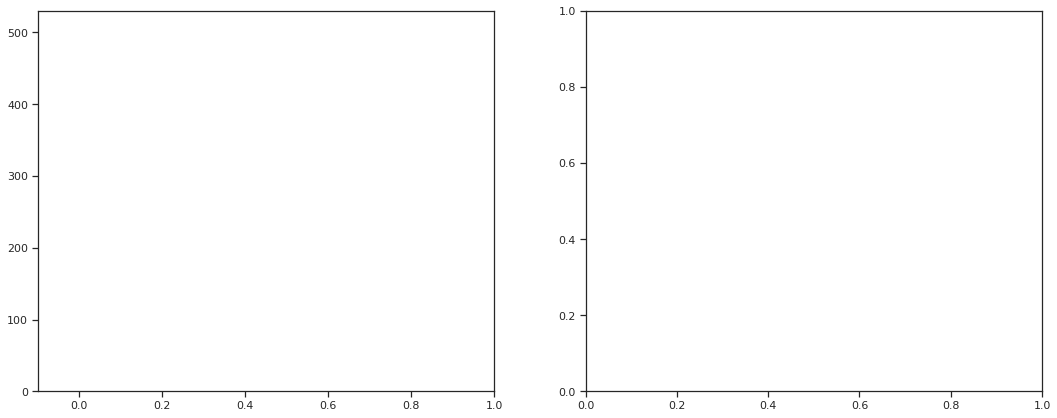

In [144]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cluster_labels = cluster_labels.astype(int)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [38]:
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def scree_plot_kmeans(data,n_max):
      range_n_clusters = range(2, n_max)
      #X_scaled = scale(data)
      X_scaled = data
      inertias = []
      silhouette = []
      var_perc = []

      for n_clusters in range_n_clusters:
          modelo_kmeans = KMeans(
                              n_clusters   = n_clusters, 
                              n_init       = 20, 
                              random_state = 0
                          )
          modelo_kmeans.fit(X_scaled)
          cluster_labels = modelo_kmeans.fit_predict(X_scaled)
          inertias.append(modelo_kmeans.inertia_)
          silhouette.append(silhouette_score(X_scaled, cluster_labels))
          tss = sum(pdist(X_scaled)**2)/X_scaled.shape[0]
          bss = tss - modelo_kmeans.inertia_
          var_perc.append(bss/tss*100)

      fig, ax = plt.subplots(1, 3, figsize=(18, 6))
      ax[0].plot(range_n_clusters, inertias, marker='o')
      ax[0].set_title("Scree Diagrama Varianza intra")
      ax[0].set_xlabel('Número clusters')
      ax[0].set_ylabel('Intra-cluster (inertia)')

      ax[1].plot(range_n_clusters, silhouette, marker='o')
      ax[1].set_title("Scree diagrama silhouette")
      ax[1].set_xlabel('Número clusters')
      ax[1].set_ylabel('Media índices silhouette');

      ax[2].plot(range_n_clusters, var_perc, marker='o')
      ax[2].set_title("Scree diagrama % Varianza")
      ax[2].set_xlabel('Número clusters')
      ax[2].set_ylabel('% de varianza explicada')

# perdí la semilla ))): no me dieron igual los scree plot

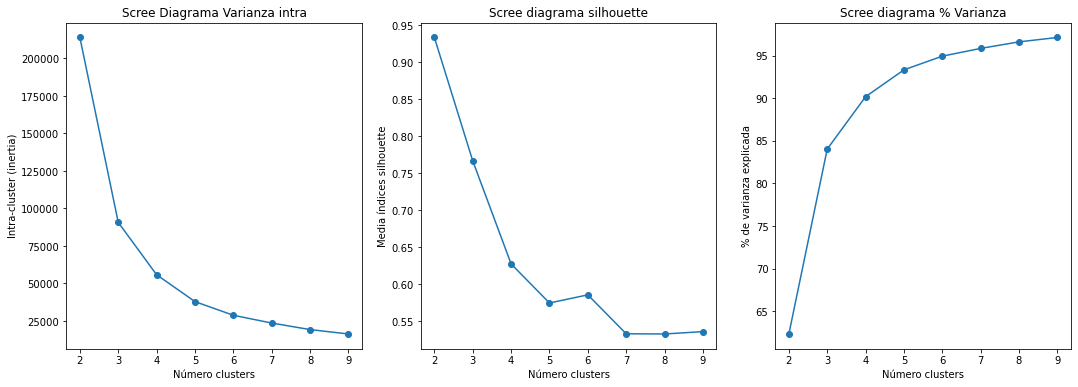

In [39]:
X=X.apply(pd.to_numeric)
data_clean = X.dropna() 
scree_plot_kmeans(data_clean,10)

#### cluster k=5

In [40]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
risk_cluster = risk
risk_cluster["cluster"] = kmeans.labels_
risk_cluster.to_csv('../resultados/resultados_4/cluster_4.csv')
risk_cluster=risk_cluster.drop(columns=['id'])
#risk_cluster = risk_cluster.replace({'cluster': {0: 'A', 1: 'B', 2: 'C', 3: 'D'}})

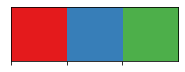

In [41]:
customPalette = ["#e41a1c", "#377eb8", "#4daf4a"]#, '#FFB139','#ec42f5'
sns.set_palette(customPalette)
sns.palplot(customPalette)

In [42]:
risk_cluster.cluster.unique()

array([2, 0, 3, 1], dtype=int32)

In [43]:
'set2' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

SyntaxError: invalid syntax (4036906291.py, line 1)

Text(0.5, 0.98, 'Matríz de gráficos de dispersión variables cluster k-means')

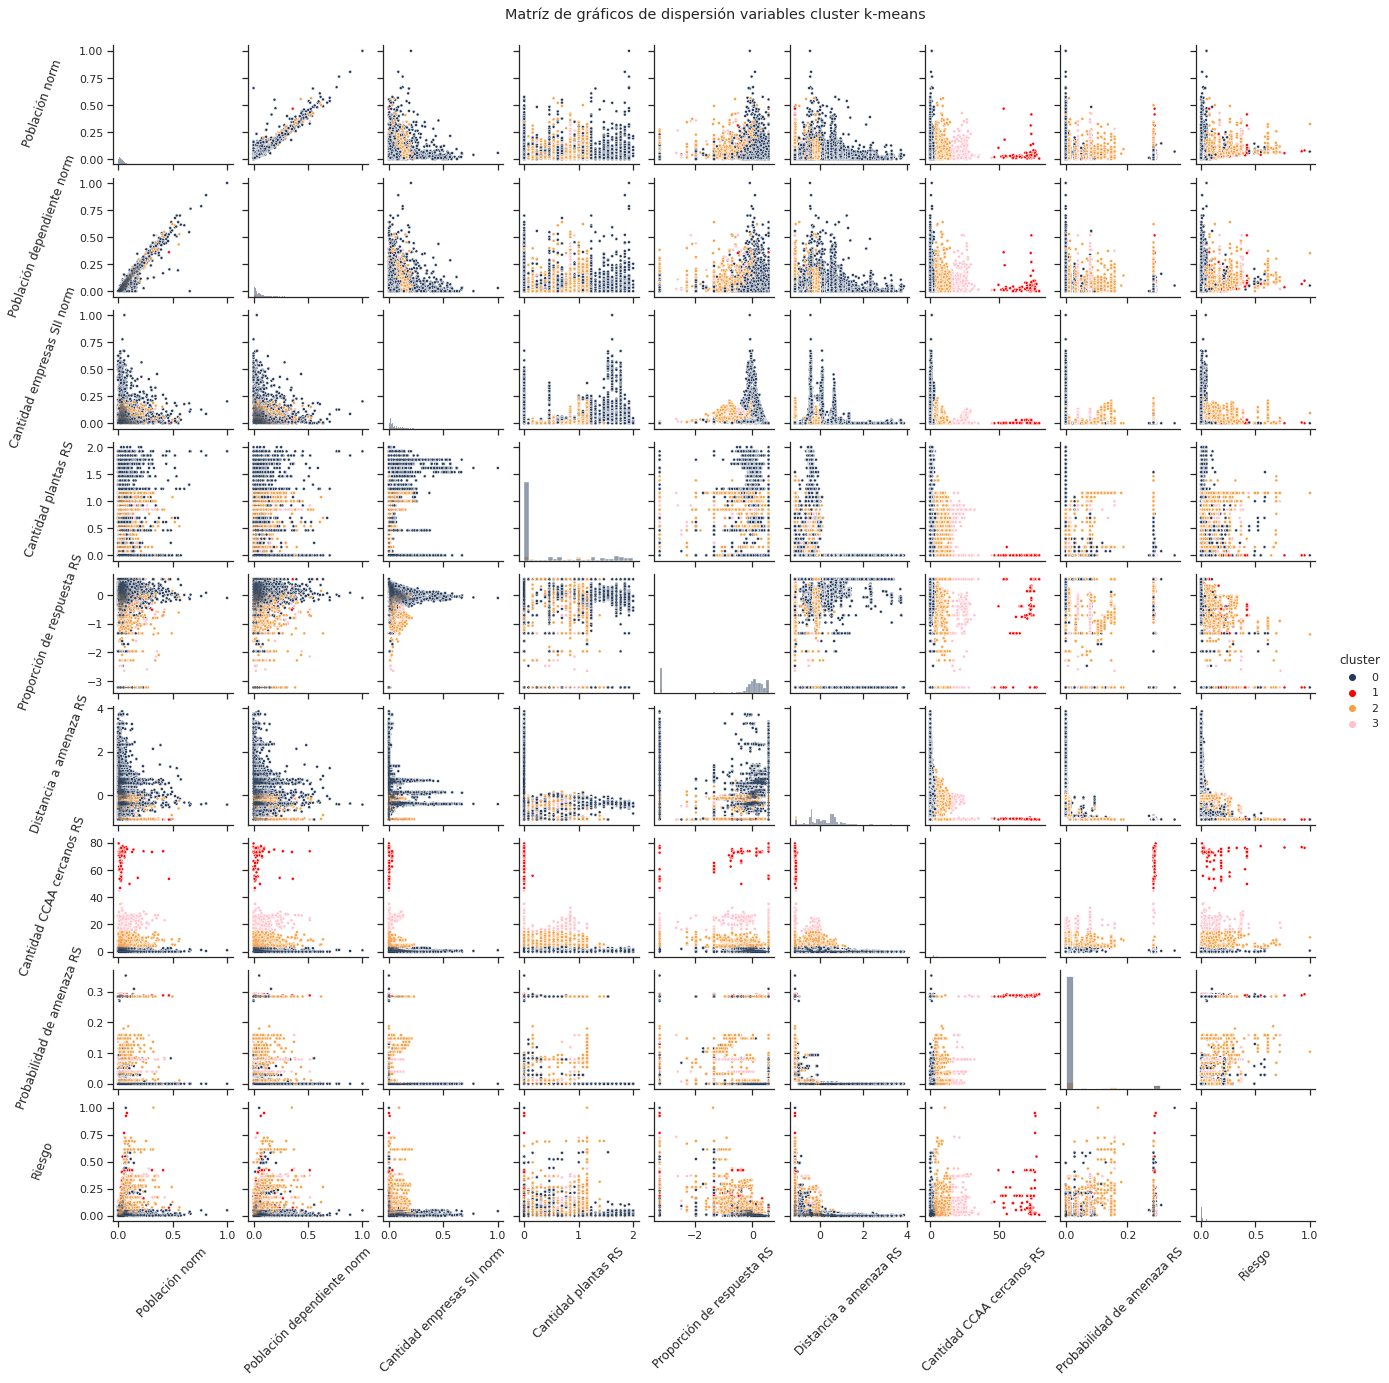

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom color palette
colors = {0: "#23395B", 1: "red", 2: "#F9A03F", 3:'blue', 3:'pink'}

# Create pairplot with custom palette
sns.set_theme(style="ticks")
g = sns.pairplot(risk_cluster, hue="cluster", diag_kind="hist", palette=colors, height=2, aspect=1, markers='.')
g.map_lower(sns.scatterplot, palette=colors, alpha=0.1, s=1)
plt.subplots_adjust(top=0.95)

# Rotating x and y axis labels
for ax in g.axes.flatten():
    # Rotate x axis labels
    ax.set_xlabel(ax.get_xlabel(), rotation = 45)
    # Rotate y axis labels
    ax.set_ylabel(ax.get_ylabel(), rotation = 70)
    # To prevent y labels overlap the axis
    ax.yaxis.labelpad = 30

g.fig.suptitle('Matríz de gráficos de dispersión variables cluster k-means')

Text(0.5, 0.98, 'Matríz de gráficos de dispersión variables cluster k-means')

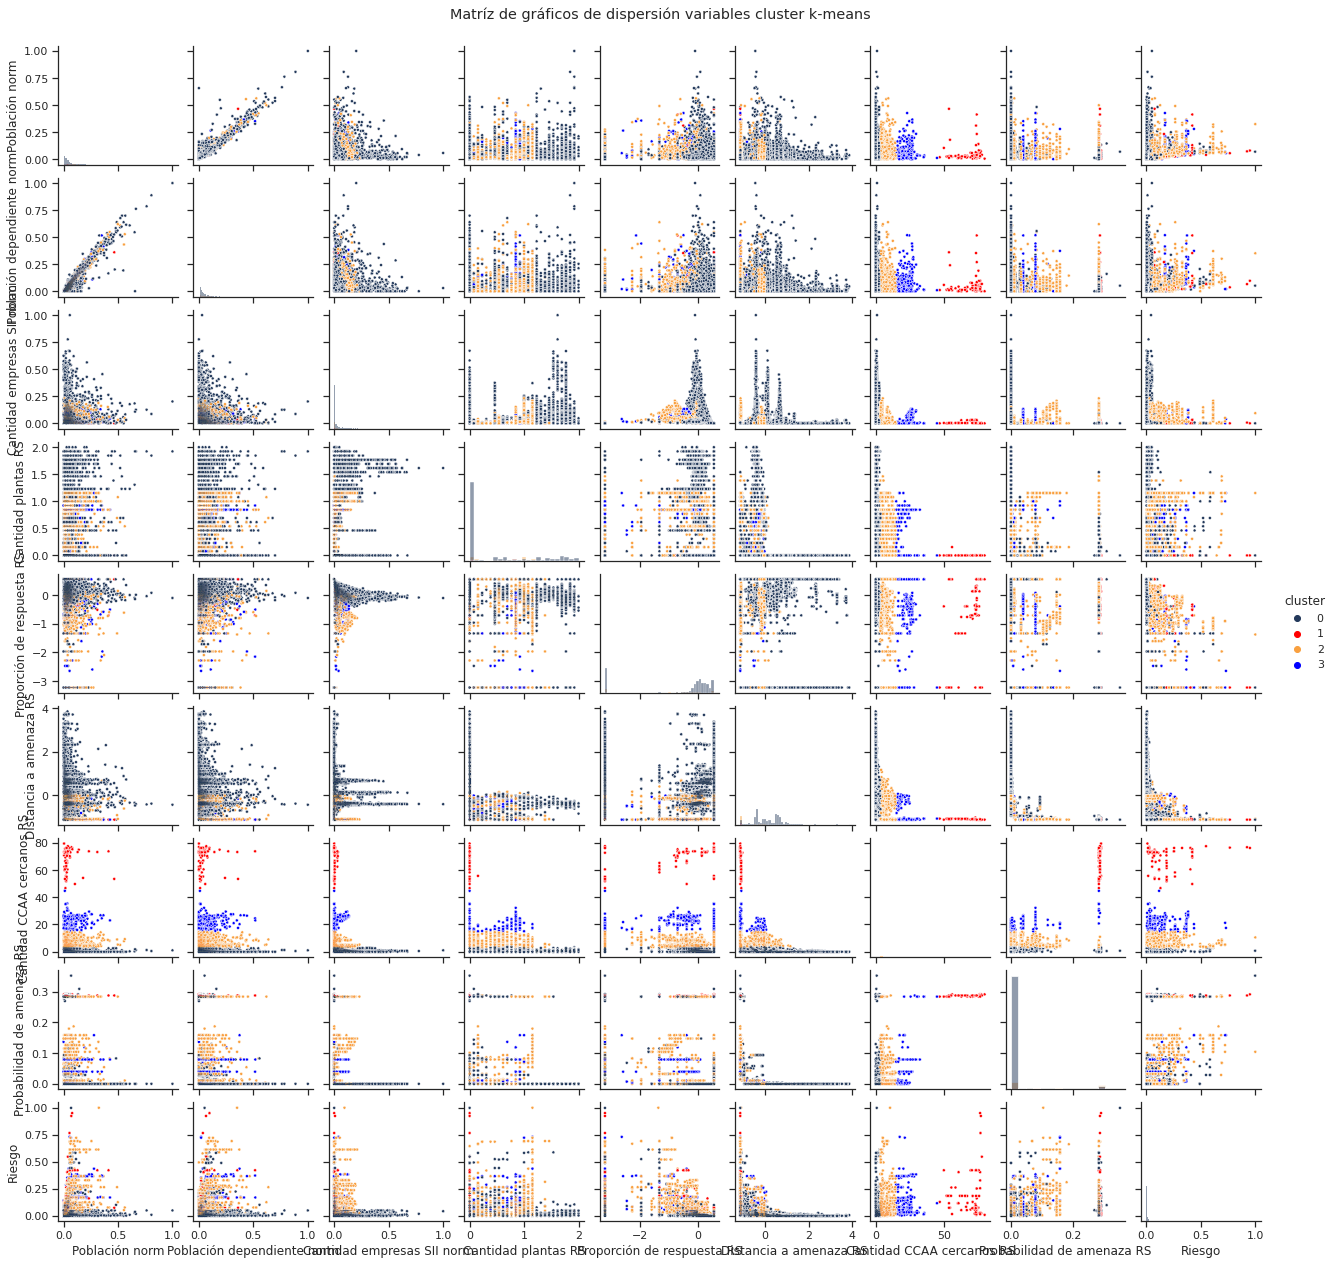

In [45]:
# Define custom color palette
colors = {0: "#23395B", 1: "red", 2: "#F9A03F", 3:'blue'}

# Create pairplot with custom palette
sns.set_theme(style="ticks")
g = sns.pairplot(risk_cluster, hue="cluster", diag_kind="hist", palette=colors, height=2, aspect=1, markers='.')
g.map_lower(sns.scatterplot, palette=colors, alpha=0.1, s=1)
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Matríz de gráficos de dispersión variables cluster k-means')

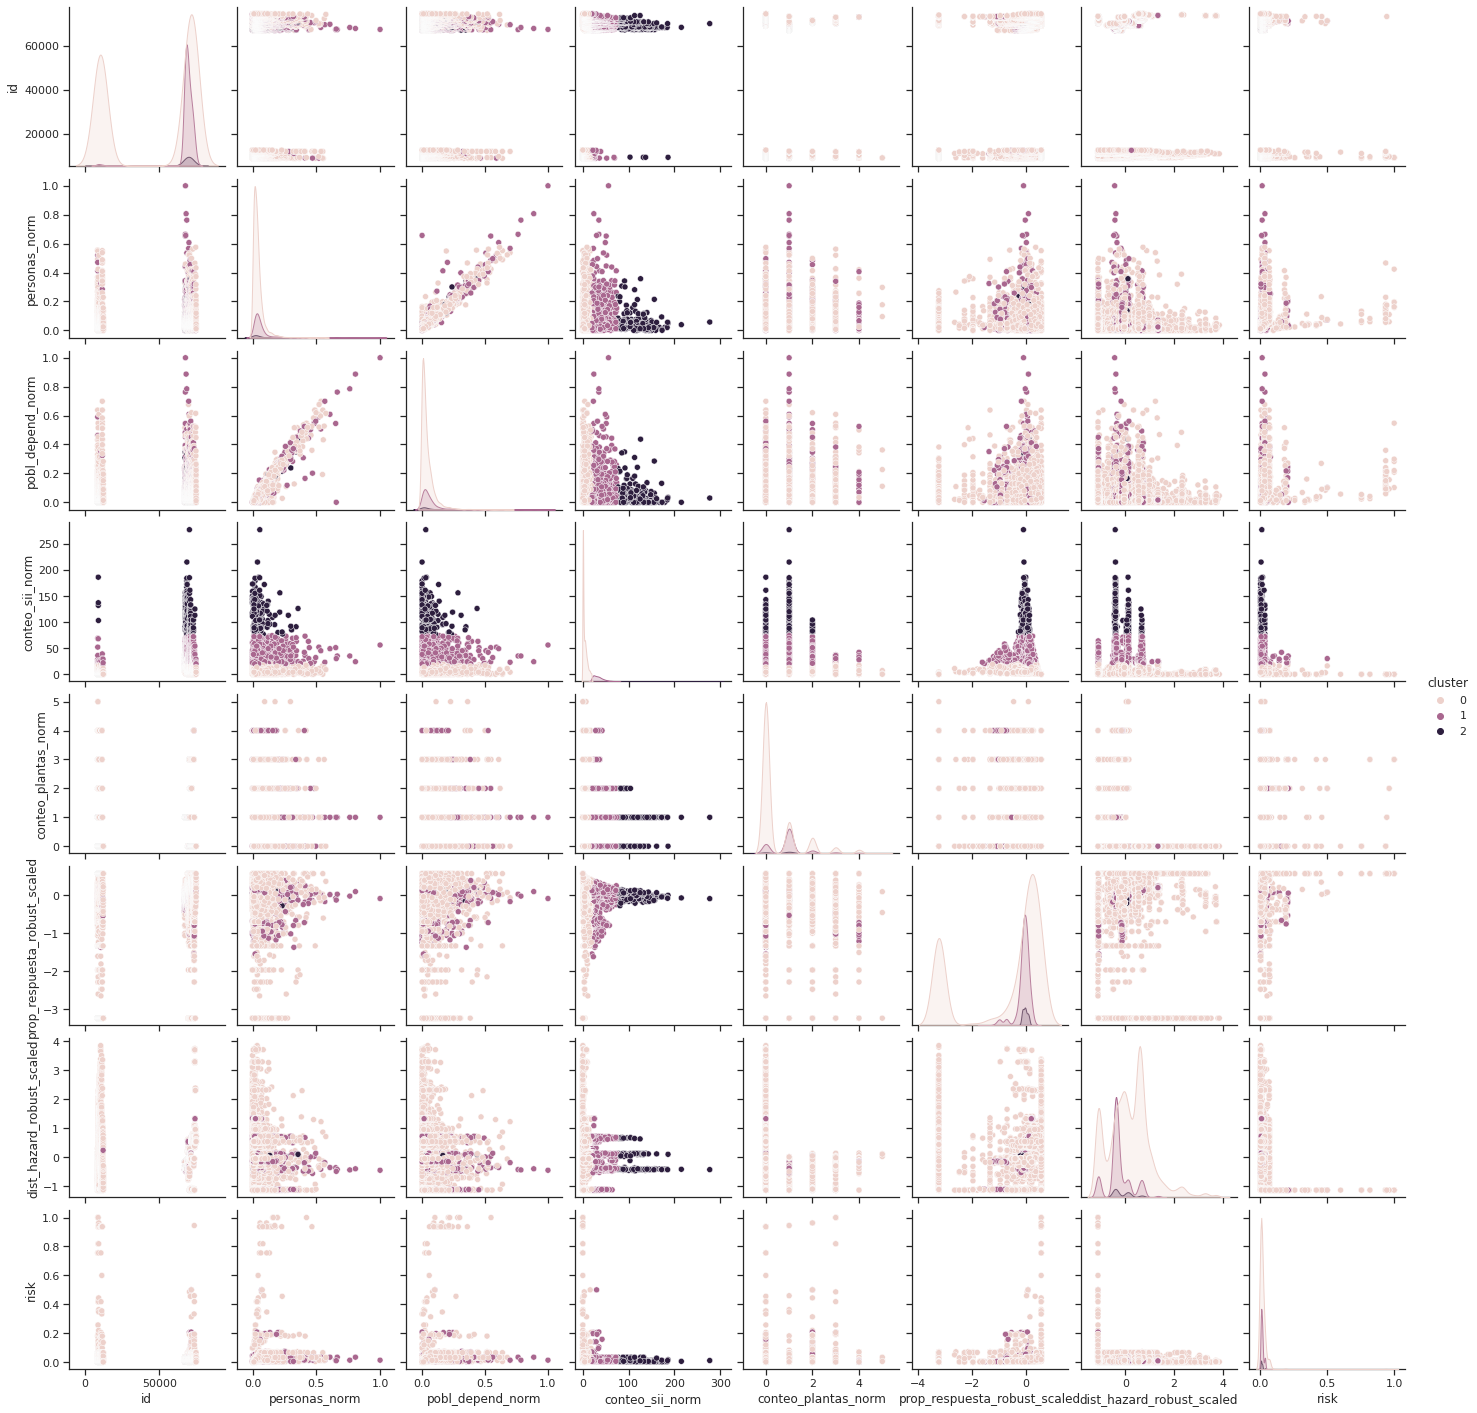

In [226]:
sns.set_theme(style="ticks")
sns.pairplot(risk_cluster, hue="cluster")

In [158]:
def plot_clusters(variable_x,variable_y):
    # get centroids
    centroids = kmeans.cluster_centers_
    cen_x = [i[0] for i in centroids] 
    cen_y = [i[1] for i in centroids]
    ## add to df
    risk_cluster['cen_x'] = risk_cluster.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
    risk_cluster['cen_y'] = risk_cluster.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})
    
    fig, ax = plt.subplots(1, figsize=(8,8))
    # plot data
    plt.scatter(risk_cluster.risk, risk_cluster.personas_norm, c=risk_cluster.cluster, alpha = 0.6, s=10)
    # plot centroids
    plt.scatter(cen_x, cen_y, marker='^', c=customPalette, s=70)
    # plot lines
    for idx, val in risk_cluster.iterrows():
        x = [val.risk, val.cen_x,]
        y = [val.personas_norm, val.cen_y]
        plt.plot(x, y, c=val.cluster, alpha=0.2)
    # legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1), 
                       markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(customPalette)]
    legend_elements.extend([Line2D([0], [0], marker='^', color='w', label='Centroid - C{}'.format(i+1), 
                markerfacecolor=mcolor, markersize=10) for i, mcolor in enumerate(customPalette)])
    legend_elements.extend(cent_leg)
    plt.legend(handles=legend_elements, loc='upper right', ncol=2)
    # x and y limits
    plt.xlim(0,200)
    plt.ylim(0,200)
    # title and labels
    plt.title('Pokemon Stats\n', loc='left', fontsize=22)
    plt.xlabel('Attack')
    plt.ylabel('Defense')

In [ ]:
"personas_norm", "pobl_depend_norm","conteo_sii_norm","conteo_plantas_robust_scaled","prop_respuesta_robust_scaled","dist_hazard_robust_scaled",'hazard_prob_robust_scaled'

In [164]:
def plot_cluster_var(dataframe,var1, var2):
    '''Funcion que grafica el riesgo vs alguna variable'''
    colors = {0: "#23395B", 1: "red", 2: "#F9A03F",3:'#ec42f5',4:'#FFB139'}
    customPalette = ["#23395B", "red", "#F9A03F"]#, '#FFB139','#ec42f5'
    sns.set_palette(customPalette)

    #plot data with seaborn (don't add a legend yet)
    facet = sns.lmplot(data=dataframe, x=var1, y=var2, hue='cluster', 
                       fit_reg=False, legend=False,scatter_kws={"alpha": 0.2, "s":50})

    #add a legend
    leg = facet.ax.legend(bbox_to_anchor=[1, 0.75],
                             title="label", fancybox=True)
    #change colors of labels
    for i, text in enumerate(leg.get_texts()):
        plt.setp(text, color = colors[i])

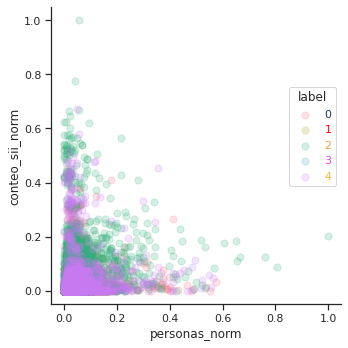

In [165]:
#risk_cluster_12=risk_cluster.drop(columns=['id'])
risk_cluster_12 = risk_cluster[risk_cluster.cluster != 2]
risk_cluster_13 = risk_cluster[risk_cluster.cluster != 1]
plot_cluster_var(risk_cluster ,'personas_norm','conteo_sii_norm')

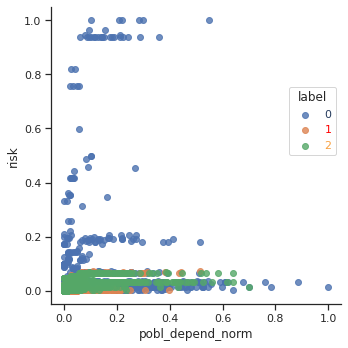

In [289]:
plot_cluster_var('pobl_depend_norm')

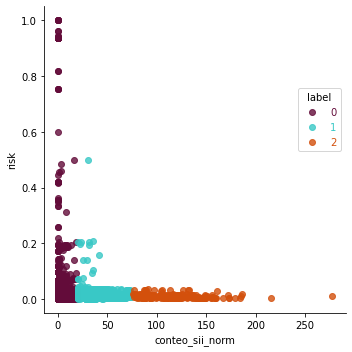

In [92]:
plot_cluster_var('conteo_sii_norm')

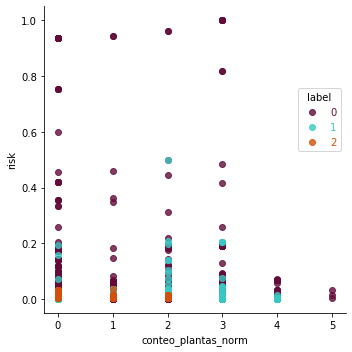

In [93]:
plot_cluster_var('conteo_plantas_robust_scaled')

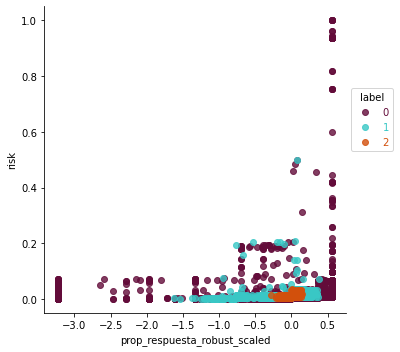

In [94]:
plot_cluster_var('prop_respuesta_robust_scaled')

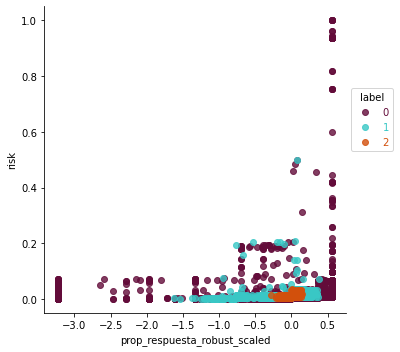

In [95]:
plot_cluster_var('prop_respuesta_robust_scaled')

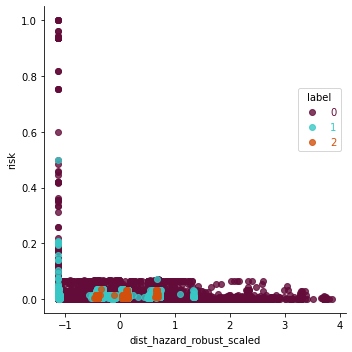

In [96]:
plot_cluster_var('dist_hazard_robust_scaled')

# gaussian mixture model

In [215]:
X=X.apply(pd.to_numeric)
X = X.dropna()

In [226]:
n_components

array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170,
       180, 190, 200])

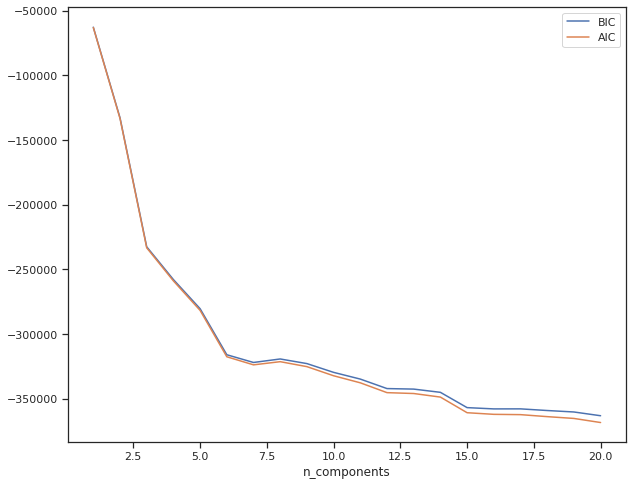

In [229]:
n_components = np.arange(1, 21)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

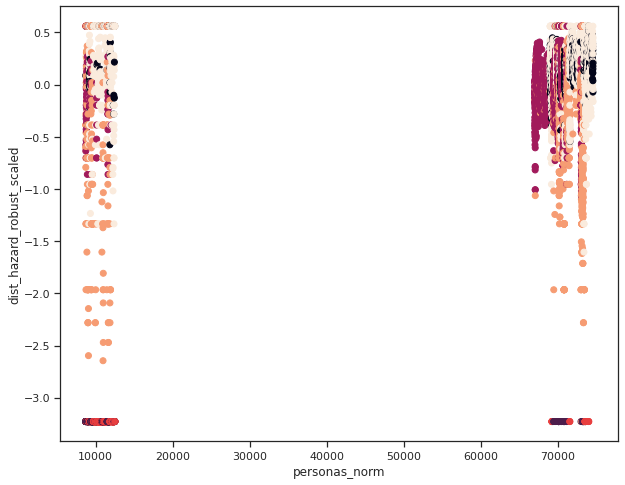

In [239]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# define the number of clusters
n_components = 6

# create the GMM model with the given number of components
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)

# fit the model to the data
gmm.fit(X)

# predict the cluster labels for each data point
labels = gmm.predict(X)

# add the predicted labels to the original data frame
X_labeled = risk.copy()
X_labeled['label'] = labels

# plot the results in 2D
plt.scatter(X_labeled.iloc[:, 0], X_labeled.iloc[:, 5], c=labels)
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[5])
plt.show()
X_labeled.to_csv('../resultados/resultados_4/gmm_4.csv')

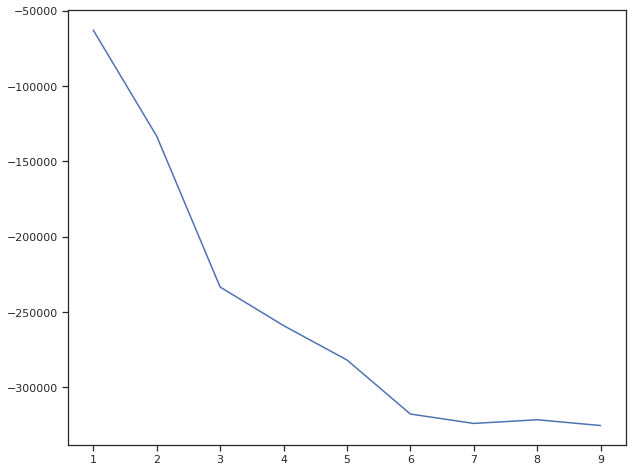

In [228]:
n_components = np.arange(1, 10, 1)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(X).aic(X) for model in models]
plt.plot(n_components, aics);
#gmm = mixture.GaussianMixture(n_components=4, covariance_type='full', random_state=0)
#plot_gmm(gmm, X)

In [216]:
from matplotlib.patches import Ellipse
from sklearn import mixture

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
        
gmm = mixture.GaussianMixture(n_components=4, covariance_type='full', random_state=0)
plot_gmm(gmm, X)

IndexError: index 1 is out of bounds for axis 1 with size 1

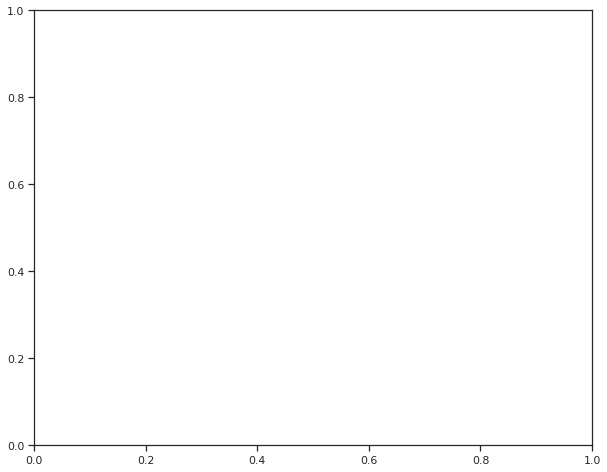

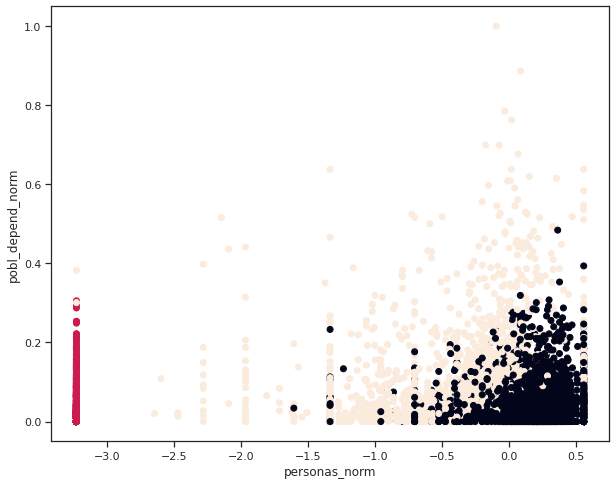

In [197]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt


n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [46]:
shp_file = "../data/GIS/procesada/riesgo_final_01.geojson"
gdf = gpd.read_file(shp_file)
cluster_df = risk_cluster[['id', 'cluster']]
gdf.merge(cluster_df, on='id', how='left')
gdf.head()
#gdf.to_file("../resultados/mapas/mapa_de_cluster.geojson", driver='GeoJSON')

,id,vulnerability,risk,edad_0_5_norm,edad_65_mas_norm,personas_norm,sii_norm,plantas_norm,geometry
0,8708,0.057129,0.049505,0.4,0.138686,0.268935,0.010870,0.0,"MULTIPOLYGON (((-72.57136 -41.64910, -72.57156..."
1,8709,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,"MULTIPOLYGON (((-72.38598 -41.47161, -72.38566..."
2,8710,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,"MULTIPOLYGON (((-72.42767 -41.50529, -72.42369..."
3,8711,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,"MULTIPOLYGON (((-72.50617 -41.43223, -72.50603..."
4,8712,0.001630,0.001288,0.0,0.000000,0.000000,0.005435,0.0,"MULTIPOLYGON (((-72.43216 -41.58239, -72.43217..."


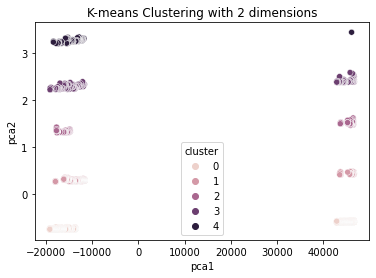

In [62]:
### Run PCA on the data and reduce the dimensions in pca_num_components dimensions

pca_num_components = 2

reduced_data = PCA(n_components=pca_num_components).fit_transform(risk_cluster)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=risk_cluster['cluster'], data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()

## Decision Trees

In [64]:
X = risk[["edad_0_5_norm", "edad_65_mas_norm", "personas_norm", "sii_norm", "plantas_norm"]]
y = risk[["risk"]]

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [66]:
model = DecisionTreeRegressor(random_state=0)
model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [67]:
importances = model.feature_importances_

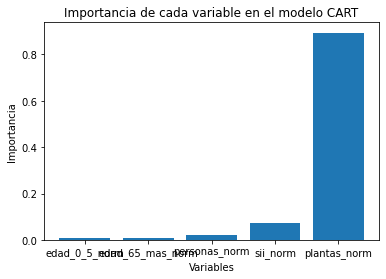

In [69]:
plt.bar(X.columns, importances)
plt.xlabel("Variables")
plt.ylabel("Importancia")
plt.title("Importancia de cada variable en el modelo CART")
plt.show()

### Selección de características

#### Select K Best

In [ ]:
X = risk[["edad_0_5_norm", "edad_65_mas_norm", "personas_norm", "sii_norm", "plantas_norm"]]
y = risk[["risk"]]

In [71]:
k = 3
selector = SelectKBest(f_regression, k=k)
selector.fit(X, y)

/home/pedro/miniconda3/envs/risk_assess/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SelectKBest(k=3, score_func=<function f_regression at 0x7f40937711f0>)

In [72]:
selected_features = X.columns[selector.get_support()].tolist()

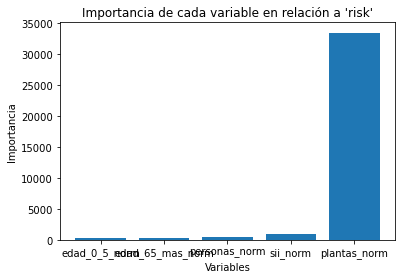

In [73]:
plt.bar(X.columns, selector.scores_)
plt.xlabel("Variables")
plt.ylabel("Importancia")
plt.title("Importancia de cada variable en relación a 'risk'")
plt.show()

# Análisis de correlación

### Corr

In [7]:
def get_raw_data():
    '''Funcion que devuelve la lista de nodos'''
    #Ingreso de parametros de conexion
    con = psycopg2.connect(database = database, user = user, 
                           password = password, host = host, port = port)
    #Creacion de conexion
    cur = con.cursor()
    #Ejecuta la conexion
    cur.execute(f''' 
                SELECT 
                    social.id, 
                    social.personas, 
                    social.pobl_depend, 
                    economic.conteo_sii, 
                    economic.conteo_plantas, 
                    response.prop_respuesta, 
                    exposure.dist_hazard,  
                    exposure.near_ccaa,
                    hazard_probability.hazard_prob as hazard_prob,
                    risk.risk
                FROM 
                    capas_estaticas.social_vulnerability as social
                JOIN
                    capas_estaticas.economic_vulnerability as economic
                    USING(id)
                JOIN 
                    capas_estaticas.response_capacity as response
                    USING(id)
                JOIN 
                    capas_estaticas.exposure_to_hazard as exposure
                    USING(id)
                JOIN 
                    capas_estaticas.risk as risk
                    USING(id)
                JOIN 
                    capas_estaticas."probability_hazard" as hazard_probability
                    USING(id)
                
                '''
                )
    #Ordena la consulta
    table = cur.fetchall()
    print("Table of raw data created successfully")
    #Se cierra la conexion
    con.close()
    #Paso a Pandas DataFrame
    table = pd.DataFrame.from_records(table,
                                          columns = ['id','Población','Población dependiente','Cantidad empresas SII','Cantidad plantas','Proporción de respuesta','Distancia a amenaza','Cantidad CCAA cercanos','Probabilidad de amenaza', 'Riesgo'])
    return table
#'Población','Población dependiente','Cantidad empresas SII','Cantidad plantas','Distancia a amenaza','Cantidad CCAA cercanos','Probabilidad de amenaza','Proporción de respuesta'

In [8]:
# se trae la consulta a la variable raw_data
risk = get_raw_data()
# fist rows
risk.head()

Table of raw data created successfully


,id,Población,Población dependiente,Cantidad empresas SII,Cantidad plantas,Proporción de respuesta,Distancia a amenaza,Cantidad CCAA cercanos,Probabilidad de amenaza,Riesgo
0,8708,245,80,2,0,0.87500000000000000000,18078.47298,30,0.00000,0.00108
1,8709,0,0,0,0,0,39436.76508,14,0.00000,0.00019
2,8710,0,0,0,0,0,35610.99132,2,0.00000,0.00019
3,8711,0,0,0,0,0,30009.27336,4,0.00000,0.00019
4,8712,0,0,1,0,0.66666666666666666667,28503.51778,2,0.00000,0.00014


In [9]:
risk=risk.apply(pd.to_numeric)
risk.describe()

,id,Población,Población dependiente,Cantidad empresas SII,Cantidad plantas,Proporción de respuesta,Distancia a amenaza,Cantidad CCAA cercanos,Probabilidad de amenaza,Riesgo
count,11047.00000,11047.00000,11047.00000,11047.00000,11047.00000,11047.00000,11045.00000,11047.00000,11047.00000,11045.00000
mean,50692.28741,74.68770,19.55146,33.10555,7.26514,0.68140,33563.66285,8.25862,0.04277,0.00162
std,28467.39390,92.60758,29.81815,51.07466,9.76379,0.36752,22853.25095,27.82602,0.10374,0.00417
min,8708.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001
25%,11469.50000,27.00000,4.00000,0.00000,0.00000,0.65385,19639.59388,0.00000,0.00000,0.00009
50%,68979.00000,52.00000,10.00000,11.00000,1.00000,0.85222,31052.83541,0.00000,0.00000,0.00024
75%,71740.50000,87.00000,25.00000,43.00000,15.00000,0.91781,47077.18597,4.00000,0.00000,0.00102
max,74551.00000,1642.00000,442.00000,399.00000,30.00000,1.00000,136948.72496,318.00000,0.52158,0.05270


In [10]:
X = risk[['Población','Población dependiente','Cantidad empresas SII','Cantidad plantas','Proporción de respuesta','Distancia a amenaza','Cantidad CCAA cercanos','Probabilidad de amenaza']]
y = risk["Riesgo"]

#'Población','Población dependiente','Cantidad empresas SII','Cantidad plantas','Distancia a amenaza','Cantidad CCAA cercanos','Probabilidad de amenaza','Proporción de respuesta'

In [11]:
X=X.apply(pd.to_numeric)
y=y.apply(pd.to_numeric)

In [12]:
y.describe()

count   11045.00000
mean        0.00162
std         0.00417
min         0.00001
25%         0.00009
50%         0.00024
75%         0.00102
max         0.05270
Name: Riesgo, dtype: float64

In [13]:
correlation_matrix = X.corr(method='kendall')

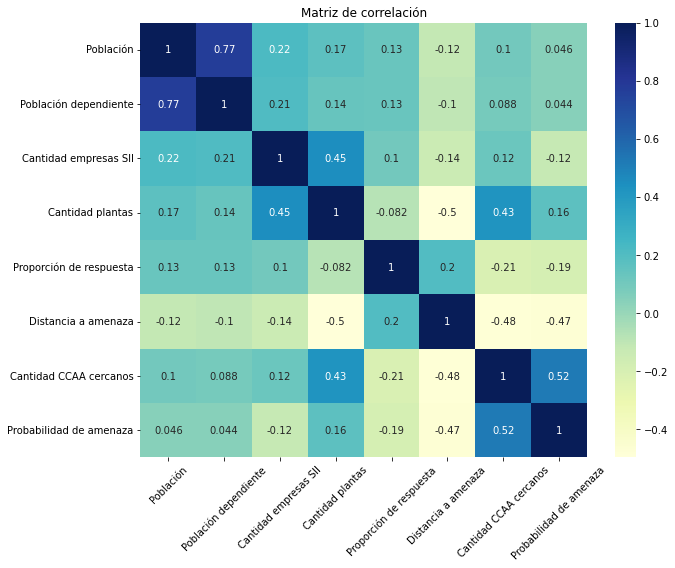

In [15]:
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu")
plt.rcParams["figure.figsize"] = (10,8)
plt.xticks(rotation=45) 
plt.title("Matriz de correlación")
plt.show()

In [17]:
correlations = X.corrwith(y)

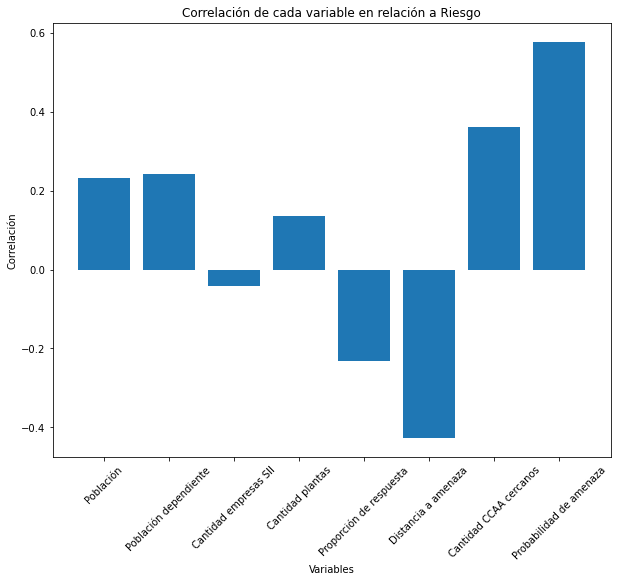

In [18]:
plt.bar(X.columns, correlations)
plt.rcParams["figure.figsize"] = (10,8)
plt.xticks(rotation=45) 
plt.xlabel("Variables")
plt.ylabel("Correlación")
plt.title("Correlación de cada variable en relación a Riesgo")
plt.show()

# Corr by type of risk

min         0
25%         0.0015
50%         0.00446
75%         0.01924
max         1

In [5]:
def get_raw_data():
    '''Funcion que devuelve la lista de nodos'''
    #Ingreso de parametros de conexion
    con = psycopg2.connect(database = database, user = user, 
                           password = password, host = host, port = port)
    #Creacion de conexion
    cur = con.cursor()
    #Ejecuta la conexion
    cur.execute(f''' 
                WITH table_risk as (
                    SELECT 
                        social.id, 
                        social.personas, 
                        social.pobl_depend, 
                        economic.conteo_sii, 
                        economic.conteo_plantas, 
                        response.prop_respuesta, 
                        exposure.dist_hazard,  
                        exposure.near_ccaa,
                        hazard_probability.hazard_prob as hazard_prob,
                        risk.risk
                    FROM 
                        capas_estaticas.social_vulnerability as social
                    JOIN
                        capas_estaticas.economic_vulnerability as economic
                        USING(id)
                    JOIN 
                        capas_estaticas.response_capacity as response
                        USING(id)
                    JOIN 
                        capas_estaticas.exposure_to_hazard as exposure
                        USING(id)
                    JOIN 
                        capas_estaticas.risk as risk
                        USING(id)
                    JOIN 
                        capas_estaticas."probability_hazard" as hazard_probability
                        USING(id)
                )
                
                SELECT 
                    id, 
                    personas, 
                    pobl_depend, 
                    conteo_sii, 
                    conteo_plantas, 
                    prop_respuesta, 
                    dist_hazard,  
                    near_ccaa,
                    hazard_prob as hazard_prob,
                    CASE 
                        WHEN risk < 0.00329 THEN 'Bajo'
                        WHEN (risk >= 0.00980 AND risk <= 0.11687) THEN 'Medio'
                        WHEN risk > 0.02477 THEN 'Alto'
                    END AS risk_class
                FROM table_risk
                '''
                )
    #Ordena la consulta
    table = cur.fetchall()
    print("Table of raw data created successfully")
    #Se cierra la conexion
    con.close()
    #Paso a Pandas DataFrame
    table = pd.DataFrame.from_records(table,
                                          columns = ['id','personas','pobl_depend','conteo_sii','conteo_plantas','prop_respuesta','dist_hazard','near_ccaa','hazard_probability', 'risk'])
    return table

In [6]:
# se trae la consulta a la variable raw_data
risk = get_raw_data()
# fist rows
risk.head()

Table of raw data created successfully


,id,personas,pobl_depend,conteo_sii,conteo_plantas,prop_respuesta,dist_hazard,near_ccaa,hazard_probability,risk
0,8708,245,80,2,0,0.87500000000000000000,18078.47298,30,0.00000,Bajo
1,8709,0,0,0,0,0,39436.76508,14,0.00000,Bajo
2,8710,0,0,0,0,0,35610.99132,2,0.00000,Bajo
3,8711,0,0,0,0,0,30009.27336,4,0.00000,Bajo
4,8712,0,0,1,0,0.66666666666666666667,28503.51778,2,0.00000,Bajo


In [124]:
risk_bajo = risk[risk.risk == 'Bajo']
risk_medio = risk[risk.risk == 'Medio']
risk_alto = risk[risk.risk == 'Alto']

In [125]:
risk_medio

,id,personas,pobl_depend,conteo_sii,conteo_plantas,prop_respuesta,dist_hazard,near_ccaa,hazard_probability,risk
31,8739,80,33,3,9,0E-20,0.53251,46,0.11511,Medio
32,8740,603,206,3,7,0.50000000000000000000,1488.87308,50,0.02518,Medio
37,8745,807,282,2,9,0.50000000000000000000,5594.68000,36,0.02518,Medio
38,8746,137,45,9,13,0.33333333333333333333,8849.04473,29,0.02518,Medio
198,8906,149,52,0,13,0,0.00000,73,0.15468,Medio
...,...,...,...,...,...,...,...,...,...,...
9854,73310,151,47,5,2,0.78947368421052631579,73.91007,32,0.21223,Medio
9855,73311,181,68,5,2,0.77777777777777777778,92.39589,27,0.21223,Medio
9863,73319,112,38,5,2,0.78260869565217391304,202.49247,33,0.25180,Medio
9866,73322,91,22,5,2,0.84210526315789473684,0.00000,33,0.25180,Medio


In [126]:
def corr_by_risk(dataframe):
    X = dataframe[["personas", "pobl_depend", "conteo_sii", "conteo_plantas", "prop_respuesta","dist_hazard"]]
    y = dataframe["risk"]
    X=X.apply(pd.to_numeric)
    correlation_matrix = X.corr(method='kendall')
    sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu")
    plt.title("Matriz de correlación")
    plt.show()

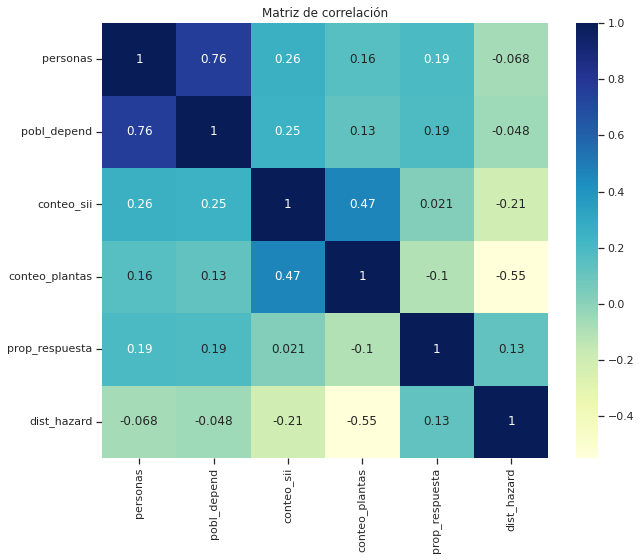

In [127]:
corr_by_risk(risk_bajo)

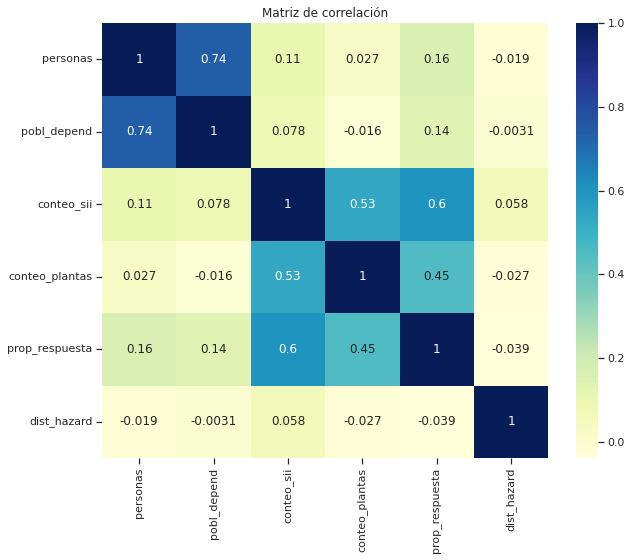

In [128]:
corr_by_risk(risk_medio)

/home/pedro/miniconda3/envs/risk_assess/lib/python3.8/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/pedro/miniconda3/envs/risk_assess/lib/python3.8/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


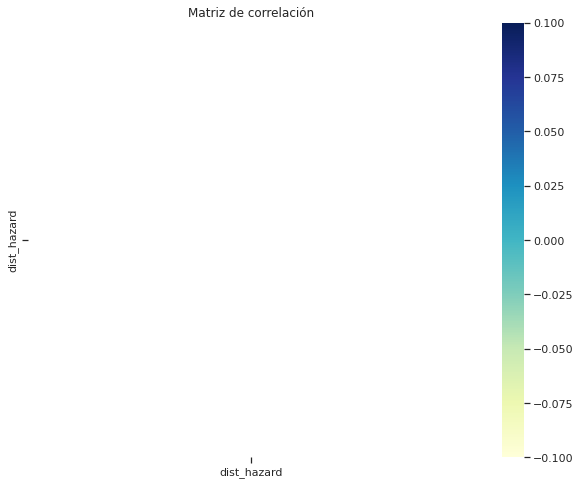

In [129]:
corr_by_risk(risk_alto)

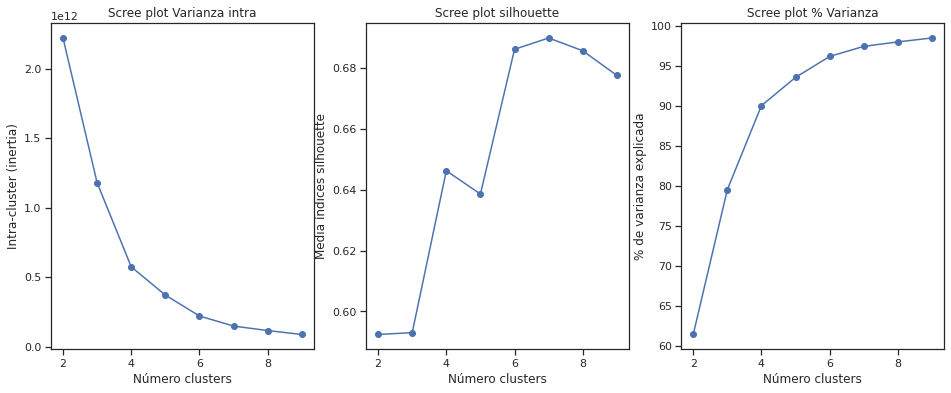

In [130]:
data_clean = X.dropna() 
scree_plot_kmeans(data_clean,10)